In [9]:
%pylab inline
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid_at_node
from landlab.components import PresFlowNetwork, MeltCreep
import numpy as np
from matplotlib import colors,  cm
import matplotlib.animation as animation

Populating the interactive namespace from numpy and matplotlib


In [7]:
from PIL import Image
from PIL import ImageDraw

def plot_links(grid, value_name, autoscale=True, vmin=0., vmax=0., cmap_name='viridis', magnitude= False, lw=5, pixels_per_node=15, x_name='X', y_name='Y', var_name='', use_PIL=True):#, logvalues=False ):
    if use_PIL:
        pixel_xscaling_factor = pixels_per_node/grid.dx
        pixel_yscaling_factor = pixels_per_node/grid.dy
        im = Image.new('RGBA', ( int(round(grid.number_of_cell_columns*pixel_xscaling_factor)), int(round(grid.number_of_cell_rows*pixel_yscaling_factor)) ), (255,255,255,255))
        draw = ImageDraw.Draw(im)

    link_head_x = grid.node_x[grid.node_at_link_head]
    link_head_y = grid.node_y[grid.node_at_link_head]
    link_tail_x = grid.node_x[grid.node_at_link_tail]
    link_tail_y = grid.node_y[grid.node_at_link_tail]       
    if magnitude:
        values = abs(grid.at_link[value_name])
    else:
        values = grid.at_link[value_name]
    #if logvalues:
    #    values = np.log10(abs(grid.at_link[value_name]))
    
    
    #Normalize color values
    if autoscale:
        cnorm = colors.Normalize()
        cnorm.autoscale(values)
    else:
        cnorm = colors.Normalize(vmin,vmax)
    scalarMap = cm.ScalarMappable(norm=cnorm, cmap = get_cmap(cmap_name))
    scalarMap.set_array(values)
    #set_cmap()
    if use_PIL:
        for i, value in enumerate(values):
            draw.line( ((link_head_x[i]*pixel_xscaling_factor,link_head_y[i]*pixel_yscaling_factor),(link_tail_x[i]*pixel_xscaling_factor,link_tail_y[i]*pixel_yscaling_factor)),fill=scalarMap.to_rgba(value,bytes=True),width=lw) 
        imshow(np.asarray(im), origin='lower', extent=(0,grid.number_of_cell_columns,0,grid.number_of_cell_rows))
    else:
        for i, value in enumerate(values):
            xs = [link_head_x[i],link_tail_x[i]]
            ys = [link_head_y[i],link_tail_y[i]]
            img = plot(xs,ys,lw=lw,color=scalarMap.to_rgba(value))    
    cb = colorbar(scalarMap)
    cb.ax.set_ylabel(var_name)
    xlabel(x_name)
    ylabel(y_name)


In [98]:
mg = RasterModelGrid((5,5),500)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
C_inflow = mg.add_zeros('node', 'input__concentration')
Cin = mg.add_zeros('link', 'conduit__conc_in')
Cout = mg.add_zeros('link', 'conduit__conc_out')
#set boundary node head

#add input to node 310
input_Q=.01
input_C = 1.
input_idx = 11
mg.at_node['input__discharge'][input_idx] = input_Q
mg.at_node['input__concentration'][input_idx] = input_C 

mg.at_node['input__discharge'][7] = 0.01
mg.at_node['input__concentration'][7] = 0.1 


#set heads at edges
h[mg.nodes_at_left_edge] = 50.
h[mg.nodes_at_right_edge] = 0.
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.
mg.set_closed_boundaries_at_grid_edges(False,True,True,True)
Q[mg.active_links] = 0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'][mg.active_links]= 0.5*np.random.rand(mg.number_of_active_links)




#code added for fsolve algorithm
#dhdx = mg.add_zeros('link', 'hydraulic_head_gradient')
#net_node_flux = mg.add_ones('node', 'net_node_flux')


pfn = PresFlowNetwork(mg)
pfn.run_one_step()


Number of links =  40
Number of nodes =  25
Number of active links =  15
Number of core nodes =  9
Number of iterations = 1 tolerance = 0.0308547947725  iteration time= 0.004801034927368164
Number of iterations = 2 tolerance = 0.0300769054872  iteration time= 0.0043125152587890625
Number of iterations = 3 tolerance = 0.0160035298737  iteration time= 0.003474712371826172
Number of iterations = 4 tolerance = 0.0102782155637  iteration time= 0.0034830570220947266
Number of iterations = 5 tolerance = 0.00417802853915  iteration time= 0.003648996353149414
Number of iterations = 6 tolerance = 0.0013019851741  iteration time= 0.0034232139587402344
Number of iterations = 7 tolerance = 0.000715945007345  iteration time= 0.0029289722442626953
Number of iterations = 8 tolerance = 0.000284189060027  iteration time= 0.0038404464721679688
Number of iterations = 9 tolerance = 9.65126668617e-05  iteration time= 0.003881216049194336
Number of iterations = 10 tolerance = 3.39023913606e-05  iteration tim

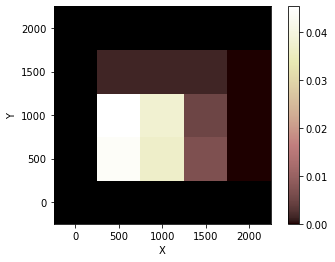

In [71]:
figure()
imshow_grid_at_node(mg, h)


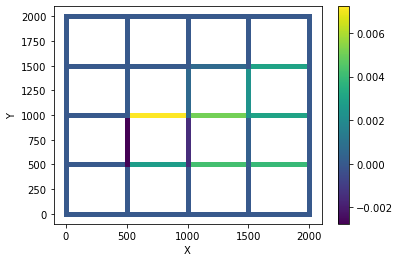

In [72]:
figure()
plot_links(mg, 'conduit__discharge', use_PIL=False)

In [62]:
mg.links_at_node[mg.core_nodes]

array([[10, 14,  9,  5],
       [11, 15, 10,  6],
       [12, 16, 11,  7],
       [19, 23, 18, 14],
       [20, 24, 19, 15],
       [21, 25, 20, 16],
       [28, 32, 27, 23],
       [29, 33, 28, 24],
       [30, 34, 29, 25]])

In [63]:
idx = np.argsort(-h[mg.core_nodes])#Sort on negative to get descending order sort

In [64]:
h[mg.core_nodes][idx]

array([  2.17681586e+00,   2.17681534e+00,   1.35221876e+00,
         1.25306115e+00,   1.44885181e-01,   1.30093264e-01,
         2.14658970e-02,   3.90161951e-03,   7.77036227e-04])

In [65]:
this_node_links = mg.links_at_node[mg.core_nodes][idx][0]
print(this_node_links)
this_node_dirs = mg.active_link_dirs_at_node[mg.core_nodes][idx][0]
print(this_node_dirs)

[19 23 18 14]
[-1 -1  0  1]


In [67]:
mg.at_link['conduit__discharge'][this_node_links]*this_node_dirs

array([ -2.80056368e-03,  -4.96500089e-05,   0.00000000e+00,
        -7.14978631e-03])

In [85]:
#First determine inflow and outflow links
node_Qs = mg.at_link['conduit__discharge'][this_node_links]*this_node_dirs
node_inflow_links = this_node_links[node_Qs>0]
node_outflow_links = this_node_links[node_Qs<0]
print(node_outflow_links)
print(node_inflow_links)

#Calculate node concentration from inflows (including boundary inflows)
total_inflow = mg.at_link['conduit__discharge'][node_inflow_links].sum() + \
                mg.at_node['input__discharge'][mg.core_nodes[idx[0]]]

conc_mult = mg.at_link['conduit__discharge'][node_inflow_links]*mg.at_link['conduit__conc_out'][node_inflow_links]
input_conc_mult = mg.at_node['input__discharge'][mg.core_nodes[idx[0]]]*mg.at_node['input__concentration'][mg.core_nodes[idx[0]]]
conc_node = (conc_mult.sum() + input_conc_mult)/total_inflow

#set outflow link concentrations
mg.at_link['conduit__conc_in'][node_outflow_links] = conc_node

#Calculate output link concentrations (for now conservative)
mg.at_link['conduit__conc_out'][node_outflow_links] = mg.at_link['conduit__conc_in'][node_outflow_links]




[19 23 14]
[]


In [99]:
#Get index of nodes sorted by descending head
idx = np.argsort(-h[mg.core_nodes])#Sort on negative to get descending order sort

for node_idx in idx:
    this_node_links = mg.links_at_node[mg.core_nodes][node_idx]
    this_node_dirs = mg.active_link_dirs_at_node[mg.core_nodes][node_idx]

    #First determine inflow and outflow links
    node_Qs = mg.at_link['conduit__discharge'][this_node_links]*this_node_dirs
    node_inflow_links = this_node_links[node_Qs>0]
    node_outflow_links = this_node_links[node_Qs<0]

    #Calculate node concentration from inflows (including boundary inflows)
    total_inflow = mg.at_link['conduit__discharge'][node_inflow_links].sum() + \
                    mg.at_node['input__discharge'][mg.core_nodes[node_idx]]

    conc_mult = mg.at_link['conduit__discharge'][node_inflow_links]*mg.at_link['conduit__conc_out'][node_inflow_links]
    input_conc_mult = mg.at_node['input__discharge'][mg.core_nodes[node_idx]]*mg.at_node['input__concentration'][mg.core_nodes[node_idx]]
    conc_node = (conc_mult.sum() + input_conc_mult)/total_inflow

    #set outflow link concentrations
    mg.at_link['conduit__conc_in'][node_outflow_links] = conc_node

    #Calculate output link concentrations (for now conservative)
    mg.at_link['conduit__conc_out'][node_outflow_links] = mg.at_link['conduit__conc_in'][node_outflow_links]




In [100]:
mg.at_link['conduit__conc_in']

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.20819647,  0.20819647,  0.        ,  1.        ,
        0.20819647,  0.20819647,  0.        ,  0.        ,  1.        ,
        0.76914186,  0.23347061,  0.        ,  1.        ,  0.76914186,
        0.23347061,  0.        ,  0.        ,  1.        ,  0.77618378,
        0.77572277,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

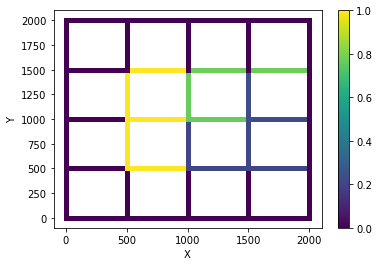

In [101]:
plot_links(mg, 'conduit__conc_in', use_PIL=False)

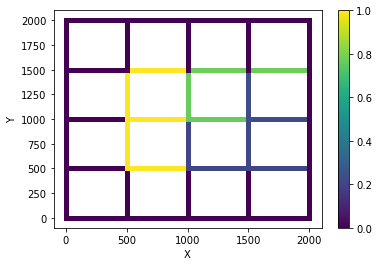

In [102]:
plot_links(mg, 'conduit__conc_out', use_PIL=False)